# 데이터 병합 및 전처리 코드
- 데이터셋 : 2021년도 기준
- 활용 데이터 : 전국 112신고접수 데이터(경찰서별), 서울시 상권분석서비스데이터, 생활안전지도 api 데이터

In [185]:
# package load
import pandas as pd
import numpy as np
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

## 서울시 지역 정보 데이터

In [186]:
# 서울시 행정동
area_adm = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_SOP_BND_ADM_DONG_PG.shp', encoding='cp949')
area_adm = area_adm.iloc[:425,:] # 서울 행정동 435개

In [187]:
# 서울시 법정동
area_law = gpd.GeoDataFrame.from_file('data/서울시위치정보/LSMD_ADM_SECT_UMD_11.shp', encoding='cp949')

## 전국 112신고접수 데이터
- 스마트치안빅데이터플랫폼 데이터셋

In [188]:
datals = os.listdir('data/전국112신고접수')
datals.sort()
datals = datals[-13:-1] # 2021년도 데이터

In [189]:
# columns
colnames = pd.read_csv('data/전국112신고접수/columns.csv', encoding='cp949')
colnames = colnames[' 컬럼영문명']
colnames.name = None

In [190]:
# data merge
df_112 = pd.DataFrame(columns=colnames)

for name in datals:
    df_i = pd.read_csv('data/전국112신고접수/'+ name, encoding='utf-8', header=None)
    df_i.columns = colnames
    df_112 = pd.concat([df_112, df_i], axis=0)

df_112 = df_112[df_112.columns.drop(['ACPT_YM'])]

In [191]:
# aggregate
df_112 = df_112.groupby('PLCST_NM', as_index=False).agg('sum')

In [192]:
# 서울 경찰서만 추리기
df_112 = df_112[df_112['PLCST_NM'].str.contains('서울')].reset_index(drop=True)
df_112.head(3)

,PLCST_NM,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,...,OCRN_TIZN_14,OCRN_TIZN_15,OCRN_TIZN_16,OCRN_TIZN_17,OCRN_TIZN_18,OCRN_TIZN_19,OCRN_TIZN_20,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23
0,서울강남,125929,64971,31098,29860,0,1124,23192,72898,14709,...,5449,5752,5424,5729,6222,5921,6240,8243,11746,9569
1,서울강동,96374,48968,26491,20914,1,901,21108,54722,8492,...,4179,4587,4654,4647,4864,5095,5218,6629,8607,7327
2,서울강북,79765,40683,24067,15015,0,492,17288,46253,6605,...,3374,3641,3681,3914,4034,4490,4721,5748,7123,5615


## 생활안전지도 데이터
생활안전지도 api에서 추출한(`safemap.ipynb`) 데이터 불러오기
> 범죄 종류 : 살인,강도,강간,절도,폭력,방화,마약,약취유인,도박,전체

In [256]:
df_safety = gpd.GeoDataFrame.from_file('safemap.gpkg')
df_safety = df_safety[df_safety['polc_se'].isin(['03_파출소', '02_지구대'])]
df_safety.columns = ['polc_nm', 'plcstn_nm', 'polc_se', '살인', '강도', '강간', '절도',
       '폭력', '방화', '마약', '약취', '도박', '전체', '시군구',
       'geometry']
df_safety.head(3) # 243 rows

,polc_nm,plcstn_nm,polc_se,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체,시군구,geometry
0,서울중부,을지로3가,03_파출소,1,1,1,1,2,1,2,1,4,2,중구,POINT (14136777.680 4518316.331)
1,서울중부,을지,02_지구대,5,1,5,4,2,1,4,1,5,4,중구,POINT (14138014.580 4518363.729)
2,서울중부,충무,03_파출소,1,1,1,1,1,1,1,1,1,1,중구,POINT (14136636.970 4517569.513)


In [260]:
df_safety = df_safety.to_crs(epsg=5181) # epsg:5181

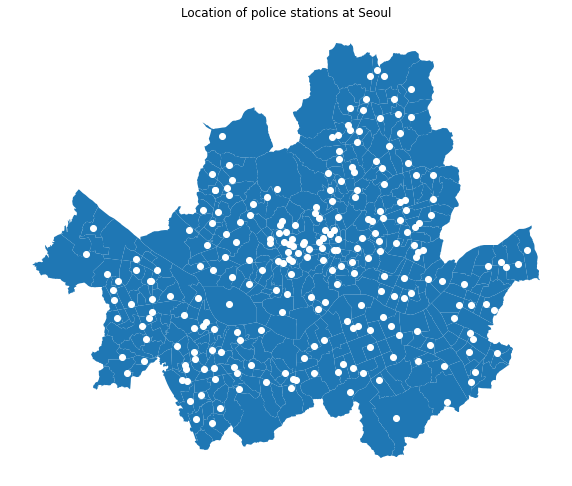

In [195]:
# plot
fig, ax = plt.subplots(figsize = (10,10))
area_adm.geometry.plot(ax=ax, zorder=1)
df_safety.geometry.plot(ax=ax, color='white', zorder = 2) # high zorder > expressed at front layer
plt.axis('off')
plt.title('Location of police stations at Seoul')
plt.show()

## 상권정보
- 서울시 우리마을가게상권분석서비스 데이터 활용

### 상권영역처리

In [196]:
# 상권영역 : 1671
commercial_area = gpd.GeoDataFrame.from_file('data/서울시_우리마을가게_상권분석서비스(신_상권영역)/TBGIS_TRDAR_RELM.shp')

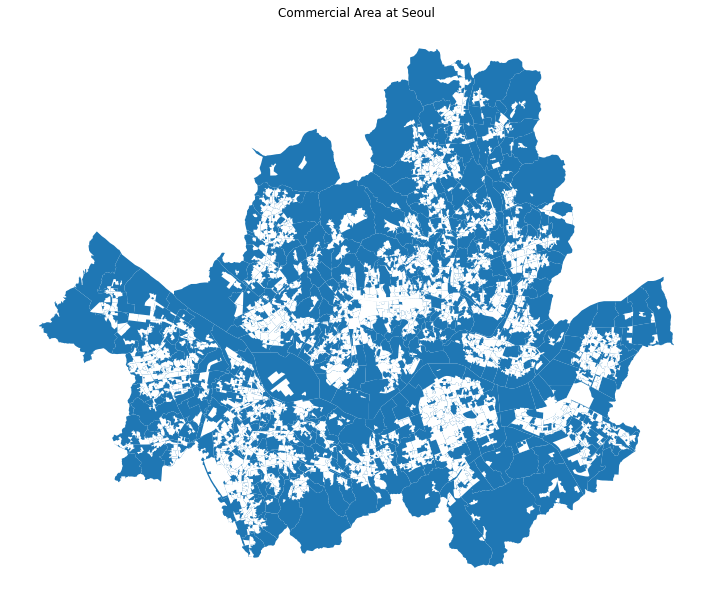

In [285]:
# plot
fig, ax = plt.subplots(figsize = (10,10))
area_adm.geometry.plot(ax=ax, zorder=1)
commercial_area.geometry.plot(ax=ax, color='white', zorder = 2) # high zorder > expressed at front layer
plt.axis('off')
plt.title('Commercial Area at Seoul')
plt.tight_layout()
plt.show()

#### 각 상권 중심점에서 가장 가까운 지구대/파출소 찾기

In [278]:
# 각 상권 중심점에서 가장 가까운 지구대/파출소 찾기
centers = commercial_area.geometry.centroid # 각 상권 중심점 좌표
commercial_area['nearest_pol_idx'] = 0 # 가장 가까운 지구대/파출소 index from df_safety

for i in tqdm(range(len(commercial_area))):
    dist_i = df_safety.geometry.distance(centers[i])
    idx_i = np.argmin(dist_i)
    commercial_area.at[i,'nearest_pol_idx'] = idx_i

100%|██████████| 1671/1671 [00:02<00:00, 787.36it/s]


In [279]:
len(commercial_area.nearest_pol_idx.unique()) # 238개 지구대/파출소 선정됨

238

### 생활인구(유동인구) 데이터 처리

In [199]:
# 생활인구 : 1668 * 4분기
df_pop = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(상권-생활인구).csv', encoding='cp949')
df_pop = df_pop[df_pop['기준 년코드']==2021]
df_pop = df_pop[df_pop.columns.drop(['기준 년코드','기준_분기_코드','상권_구분_코드',' 상권_구분_코드_명', '상권_코드_명'])]

In [200]:
# 생활인구 분기별 > 연도별 총합(aggregation with sum)
df_pop = df_pop.groupby('상권_코드', as_index=False).agg('sum')
df_pop.head(3)

,상권_코드,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,1001491,6673032,3322573,3350463,390420,1613165,1574071,1092169,864926,1138283,...,11950,12426,16114,10620,19667,17054,11450,11986,15779,10569
1,1001492,14476044,7456054,7019988,402355,2590844,3743033,3307562,2312510,2119738,...,41754,37891,19053,5354,8163,15069,20306,19320,13592,5020
2,1001493,12232536,5900582,6331955,461251,2233625,3147765,2459986,1842670,2087240,...,24412,21856,19075,11416,20886,21630,18529,17987,20942,18096


### 상권 인근 아파트 데이터
상권 인근의 아파트 단지 수 및 평균 시가 정보

In [202]:
# 상권_아파트 > 아파트 단지수와 평균시가만 사용 > aggregate
df_apt = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(상권-아파트).csv', encoding='cp949', usecols=['상권_코드','아파트_단지_수','아파트_평균_시가'])
df_apt = df_apt.groupby('상권_코드', as_index=False).agg({'아파트_단지_수' : 'max', '아파트_평균_시가' : 'mean'}).round(0)
df_apt.head(3)

,상권_코드,아파트_단지_수,아파트_평균_시가
0,1001491,71,396684548.0
1,1001493,11,247400571.0
2,1001494,8,111028306.0


### 상권내 점포 데이터
상권의 2021년도 점포수를 기준으로 개업률, 폐업률 및 프랜차이즈 침투율 계산

In [231]:
# 점포 정보 : 1665개
df_store = pd.read_csv('data/서울시_우리마을가게_상권분석서비스(신_상권_점포)_2021년.csv', encoding='cp949')
df_store = df_store[['기준_분기_코드','상권_코드', '점포_수', '개업_점포_수', '폐업_점포_수', '프랜차이즈_점포_수']]

In [232]:
# 분기별로 sum aggregate
df_store = df_store.groupby(by=['기준_분기_코드','상권_코드'],as_index=False).agg('sum')

In [280]:
# 점포수 기준은 1분기로 하여 개업율, 폐업율, 프랜차이즈 침투율 게산
df_store = df_store.groupby(by='상권_코드', as_index=False).agg(
    {'점포_수' : lambda x: x.iloc[0], '개업_점포_수' : 'sum', '폐업_점포_수' : 'sum', '프랜차이즈_점포_수' : 'sum'}
    )
df_store['개업율'] = (df_store['개업_점포_수'] / df_store['점포_수']).round(3)
df_store['폐업율'] = (df_store['폐업_점포_수'] / df_store['점포_수']).round(3)
df_store['프랜차이즈_침투율'] = (df_store['프랜차이즈_점포_수'] / df_store['점포_수']).round(3)
df_store.head(3)

,상권_코드,점포_수,개업_점포_수,폐업_점포_수,프랜차이즈_점포_수,개업율,폐업율,프랜차이즈_침투율
0,1001491,1633,172,179,330,0.105,0.110,0.202
1,1001492,8462,365,700,2473,0.043,0.083,0.292
2,1001493,12490,256,1058,782,0.020,0.085,0.063


## 서울시 유흥업소 정보
스마트치안빅데이터플랫폼의 **도시구분과 관서별 유흥시설 데이터(LH)** 활용 </br>
> 전국단위 데이터이므로 서울시 경찰관서 관내로 한정(2711개)

In [251]:
df_bars = gpd.GeoDataFrame.from_file('data/KLH_15_20211115_G_001/KLH_15_20211115_G_001.shp')
df_bars = df_bars[df_bars.PS_NM.str.startswith('서울')]
df_bars = df_bars[['PS_NM','PSS_NM','geometry']].reset_index(drop=True)

In [277]:
# 각 상권 내에 포함된 유흥업소 개수 count
commercial_area['유흥업소'] = 0

for i in tqdm(range(len(commercial_area))):
    # within function
    bar_i = np.where(df_bars.geometry.within(commercial_area.geometry[i]))[0] # 1D array
    commercial_area.at[i,'유흥업소'] = len(bar_i)

commercial_area.head(3)

100%|██████████| 1671/1671 [00:09<00:00, 172.62it/s]


,STDR_YM_CD,TRDAR_SE_C,TRDAR_SE_1,TRDAR_NO,TRDAR_NM,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,ADSTRD_CD,geometry,nearest_pol_idx,유흥업소
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934.0,438813.0,11545,11545710,"POLYGON ((192008.560 438553.170, 191987.740 43...",125,4
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265.0,459431.0,11350,11350611,"POLYGON ((206296.880 459321.710, 206238.710 45...",145,0
2,202112,A,골목상권,2110755,동일여자고등학교,192300.0,439070.0,11545,11545680,"POLYGON ((192443.040 439028.230, 192507.940 43...",125,0


### 추정매출

In [281]:
df_sales 

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2021,1,A,골목상권,2110001,이북5도청사,CS100001,한식음식점,626851391,25502,...,157,15667,7253,108,1098,2013,4344,7792,7568,28
1,2021,1,A,골목상권,2110001,이북5도청사,CS100008,분식전문점,122957138,12039,...,0,6679,4293,52,926,1222,2698,3404,2670,9
2,2021,1,A,골목상권,2110001,이북5도청사,CS100009,호프-간이주점,5093349,177,...,9,124,36,0,0,9,18,62,71,3
3,2021,1,A,골목상권,2110001,이북5도청사,CS100010,커피-음료,13507733,1359,...,8,356,881,0,243,260,213,288,235,5
4,2021,1,A,골목상권,2110001,이북5도청사,CS200001,일반교습학원,37551380,128,...,0,56,72,0,0,8,96,8,16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140825,2021,4,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,997157377,14124,...,423,6916,5717,105,3128,4161,2715,1194,1328,5
140826,2021,4,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,11911789492,6524,...,0,2704,3820,0,23,494,1493,1634,2880,6
140827,2021,4,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1717076948,8760,...,66,3585,4551,144,1800,1852,1392,926,2021,8
140828,2021,4,U,관광특구,1001496,강남 마이스 관광특구,CS300035,인테리어,12566919,370,...,0,0,370,0,0,0,0,370,0,4


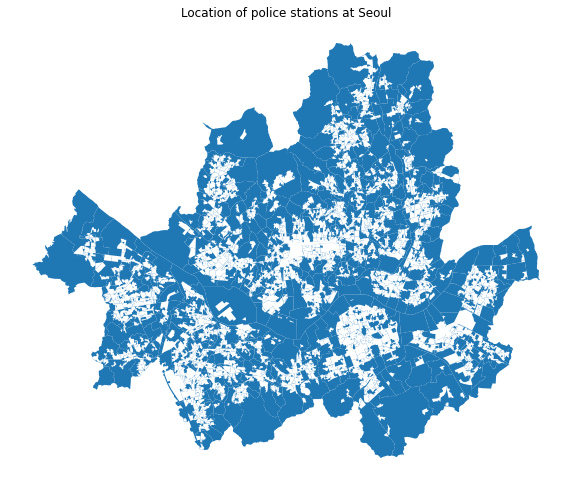

In [283]:
# plot
fig, ax = plt.subplots(figsize = (10,10))
area_adm.geometry.plot(ax=ax, zorder=1)
commercial_area.geometry.plot(ax=ax, color='white', zorder = 2) # high zorder > expressed at front layer
plt.axis('off')
plt.title('Commercial Area at Seoul')
plt.show()

In [286]:
commercial_area

,STDR_YM_CD,TRDAR_SE_C,TRDAR_SE_1,TRDAR_NO,TRDAR_NM,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,ADSTRD_CD,geometry,nearest_pol_idx,유흥업소
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934.0,438813.0,11545,11545710,"POLYGON ((192008.560 438553.170, 191987.740 43...",125,4
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265.0,459431.0,11350,11350611,"POLYGON ((206296.880 459321.710, 206238.710 45...",145,0
2,202112,A,골목상권,2110755,동일여자고등학교,192300.0,439070.0,11545,11545680,"POLYGON ((192443.040 439028.230, 192507.940 43...",125,0
3,202112,A,골목상권,2110739,시흥3동 우편취급국,191289.0,438014.0,11545,11545690,"POLYGON ((191390.840 437878.790, 191371.650 43...",127,0
4,202112,A,골목상권,2111017,송파나루역 3번,210222.0,445516.0,11710,11710562,"POLYGON ((210354.670 445450.290, 210314.560 44...",138,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1666,202112,U,관광특구,1001493,동대문패션타운 관광특구,200974.0,451975.0,11140,11140590,"POLYGON ((201553.986 452217.686, 201565.113 45...",4,8
1667,202112,U,관광특구,1001494,종로·청계 관광특구,199768.0,452273.0,11110,11110615,"POLYGON ((198035.749 452283.911, 198019.497 45...",39,7
1668,202112,U,관광특구,1001495,잠실 관광특구,210191.0,446339.0,11710,11710566,"POLYGON ((208228.914 445674.947, 208197.649 44...",137,4
1669,202112,U,관광특구,1001496,강남 마이스 관광특구,205310.0,445727.0,11680,11680580,"POLYGON ((205328.897 446048.923, 205339.561 44...",174,1


In [ ]:
gpd.overlay(commercial_area, )